# Synthetic model building #
Create thousands of random geologic models for ML (parallel implementation with Dask)

In [1]:
# Import all the packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import velocity.mdlbuild as mdlbuild
from scaas.wavelet import ricker
from genutils.ptyprint import progressbar
import genutils.rand as rndut
import deeplearn.utils as dlut
from scipy.ndimage import gaussian_filter
from genutils.signal import bandpass
import h5py
from timeit import default_timer as timer

In [2]:
# Define the total number of velocity/reflectivity models. (For this example I will be using only 20 models)
n_samples = 20

# Create lists to store the models 
VEL = []      # Contains velocity models 
REF = []      # Contains reflectivity models
IMG = []      # Contains 'fake' seismic images after convolving reflectivity with a depth dependent wavelet
VEL_MIG = []  # Contains migration (smoothed) velocity models

In [3]:
# First, I define a serial modeling function, which takes the model ID as the only input.
# The serial modeling function builds velocity/reflectivity distributions from a number of geologic events 
def stdmodel(i):
    """
    Input:   [int] 
        model ID    

    Outputs: [2D numpy arrays]
        velr        - real velocity model
        data_vel_s  - migration velocity model
        ref         - reflectivity model
        img         - fake seismic image
    """
    # Dimensions of the model
    nz = 1000; dz = 12.0
    nx = 1000; dx = 25.0
    ny = 20;   dy = 25.0; slcy = 10
    
    # Velocity limits 
    minvel = 1600; maxvel = 5500

    # Create model building object
    mb = mdlbuild.mdlbuild(nx,dx,ny,dy,dz,basevel=maxvel)
    
    # Generate the v(z) velocity gradient, defining the number of deposition layers and their thicknesses  
    nlayer = 20
    props = mb.vofz(nlayer,minvel,maxvel)
    thicks = np.random.randint(40,61,nlayer)
    
    # Determine the folding layers. The first argument controls the number of layers to fold and the last determines the minimum spacing between the layers to be folded
    sqlyrs = sorted(mb.findsqlyrs(3,nlayer,5))
    print("Folding lyrs %d, %d and %d"%(sqlyrs[0],sqlyrs[1],sqlyrs[2]))
    
    # Loop over all deposits to create the model. It builds the model from top to bottom.
    csq = 0
    for ilyr in progressbar(range(nlayer), "ndeposit:", 40):
        mb.deposit(velval=props[ilyr],thick=thicks[ilyr],layer=150,layer_rand=0.00,                         dev_layer=0.1)
        # Random folding
        if(ilyr in sqlyrs):
            if(sqlyrs[csq] < 15):
                # Random amplitude variation in the folding
                amp = np.random.rand()*(3000-500) + 500 
                mb.squish(amp=amp,azim=90.0,lam=0.4,rinline=0.0,rxline=0.0,mode='perlin')
            elif(sqlyrs[csq] >= 15 and sqlyrs[csq] < 18):
                amp = np.random.rand()*(1800-500) + 500 
                mb.squish(amp=amp,azim=90.0,lam=0.4,rinline=0.0,rxline=0.0,mode='perlin')
            else:
                amp = np.random.rand()*(500-300) + 300
                mb.squish(amp=amp,azim=90.0,lam=0.4,rinline=0.0,rxline=0.0,mode='perlin')
            csq += 1

    # Water deposit
    #mb.deposit(1480,thick=50,layer=150,dev_layer=0.0)
        
    # Smooth any unconformities
    mb.smooth_model(rect1=1,rect2=5,rect3=1)

    # Trim model before faulting
    mb.trim(0,nz+100)

    # Fault it up!
    azims = [0.0,180.0]
    fprs  = [True,False]

    # Large faults
    nlf = np.random.randint(2,5)
    for ifl in progressbar(range(nlf), "nlfaults:", 40):
        azim = np.random.choice(azims)
        fpr  = np.random.choice(fprs)
        xpos = rndut.randfloat(0.1,0.9)
        mb.largefault(azim=azim,begz=0.65,begx=xpos,begy=0.5,dist_die=2.0,tscale=6.0,fpr=fpr,twod=True)

    # Medium faults
    nmf = np.random.randint(3,6)
    for ifl in progressbar(range(nmf), "nmfaults:", 40):
        azim = np.random.choice(azims)
        fpr  = np.random.choice(fprs)
        xpos = rndut.randfloat(0.05,0.95)
        mb.mediumfault(azim=azim,begz=0.65,begx=xpos,begy=0.5,dist_die=2.0,tscale=3.0,fpr=fpr,twod=True)

    # Small faults (sliding or small)
    nsf = np.random.randint(5,10)
    for ifl in progressbar(range(nsf), "nsfaults:", 40):
        azim = np.random.choice(azims)
        xpos = rndut.randfloat(0.05,0.95)
        zpos = rndut.randfloat(0.2,0.5)
        mb.smallfault(azim=azim,begz=zpos,begx=xpos,begy=0.5,dist_die=2.0,tscale=2.0,fpr=fpr,twod=True)

    # Tiny faults
    ntf = np.random.randint(5,10)
    for ifl in progressbar(range(ntf), "ntfaults:", 40):
        azim = np.random.choice(azims)
        xpos = rndut.randfloat(0.05,0.95)
        zpos = rndut.randfloat(0.15,0.3)
        mb.tinyfault(azim=azim,begz=zpos,begx=xpos,begy=0.5,dist_die=2.0,tscale=2.0,fpr=fpr,twod=True)

    # Get model
    vel = gaussian_filter(mb.vel[:,:nz],sigma=0.5).astype('float32')
    
    # Ensure that vmax == 5500 m/s
    vel = np.where(vel <= maxvel, vel, maxvel)

    # Resize the output. For my implementation I used 256*256 images.
    nzo = 256; nxo = 256
    velr = dlut.resample(vel,[nxo,nzo],kind='quintic')
    
    # Convert from m/s to km/s for numerical stability
    velr /= 1000.

    # Impose a flat 1.5 km/s watter bottom at the top of the model for simplicity
    velr[:,0:10]=1.5
    
    # Calculate reflectivity and shift to match vel in depth
    refr = mb.calcrefl2d(velr)
    
    # Get migration velocity model
    #data_vel_s, refl =vel_smooth(velr)
    data_vel_s = gaussian_filter(velr,sigma=1).astype('float32')
    #data_vel_s[:,0:10]=1.5 # Uncomment to impose non-smooth water bottom for migration filtering  

    # Create a fake migrated image
    # Ricker wavelet parameters
    nt = 250; ot = 0.0; dt = 0.001; ns = int(nt/2)
    amp = 1.0; dly = 0.125
    minf = 99.0; maxf = 140.0
    # Compute ricker wavelet with random frequency 
    f = rndut.randfloat(minf,maxf)
    wav = ricker(nt,dt,f,amp,dly)

    # Convolve with reflectivity
    img = dlut.normalize(np.array([np.convolve(refr[ix,:],wav) for ix in range(nxo)])[:,ns:nzo+ns])
    # Create noise
    # nze = dlut.normalize(bandpass(np.random.rand(nxo,nzo)*2-1, 2.0, 0.01, 2, pxd=43))/rndut.randfloat(3,5)
    # img += nze

    # correct odd shift in depth
    # img = np.roll(img,2)
    # img[:,0:10]=0.
    # refr = np.roll(refr,2)
    # refr[:,0:10]=0.
    
    return velr, refr, img, data_vel_s

## Parallel implementation ##
I will generate models in parallel by launching the dask.distributed scheduler on a local cluster, and have the serial modeling function run in parallel over the nodes.

In [4]:
# First, let's create a list to store results from each worker
futures = []
# Then, I initiate a dask client
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(client)

<Client: 'tcp://127.0.0.1:44437' processes=8 threads=40, memory=135.07 GB>


In [5]:
# Parallel modeling implementation
start = timer()
# Distribute one model function per worker
for i in range(n_samples):
    futures.append(client.submit(stdmodel,i))    
# Collect results    
VEL = [future.result()[0] for future in futures if(future.result()[0].min() == 1.5)]
REF = [future.result()[1] for future in futures if(future.result()[0].min() == 1.5)]
IMG = [future.result()[2] for future in futures if(future.result()[0].min() == 1.5)]
VEL_MIG = [future.result()[3] for future in futures if(future.result()[0].min() == 1.5)]
end = timer()
print('elapsed time: ' + str(end - start)) # Time in seconds, e.g. 5.38091952400282

# Get the total number of models collected. Most of the time this will be less than n_samples due to some inconsistencies. But is good for now!
print(str(len(VEL))+' models created')

109.67252691369504
16


In [6]:
# Save the data set in a HDF5 file
train_path='/opt/resfoc/notebooks/external/train_models.h5'
with h5py.File(train_path,'w') as hdf:
    for i in range(len(VEL)):
        hdf.create_dataset("velocity/vel"+str(10000+i),data=VEL[i],dtype='float32')
        hdf.create_dataset("velocity_mig/vel"+str(10000+i),data=VEL_MIG[i],dtype='float32')
        hdf.create_dataset("image/vel"+str(10000+i),data=IMG[i],dtype='float32')
        hdf.create_dataset("reflectivity/vel"+str(10000+i),data=REF[i],dtype='float32')


## Plotting the first 4 models##

Loading data


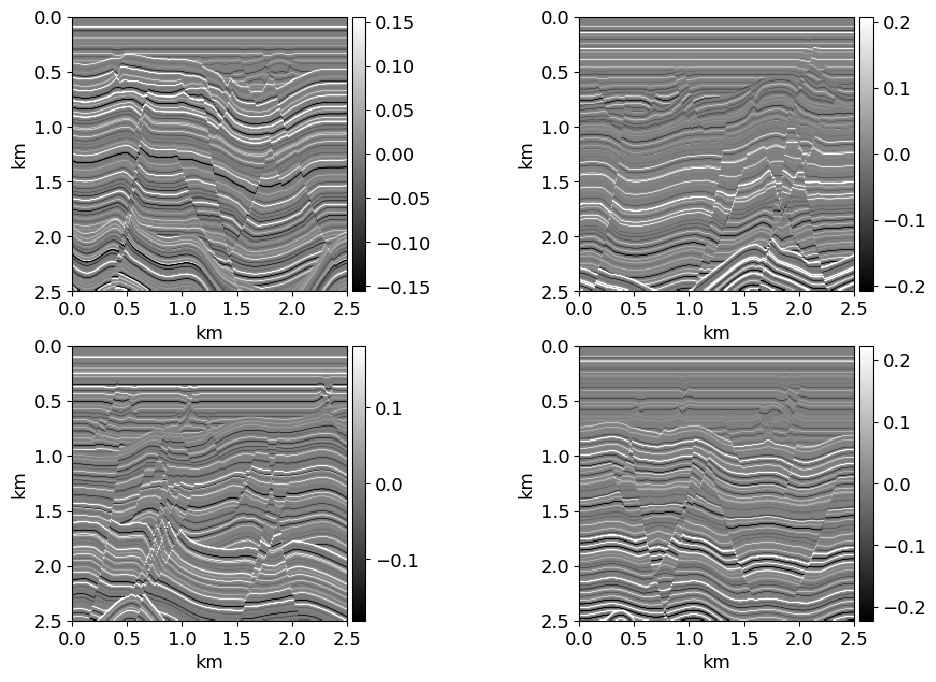

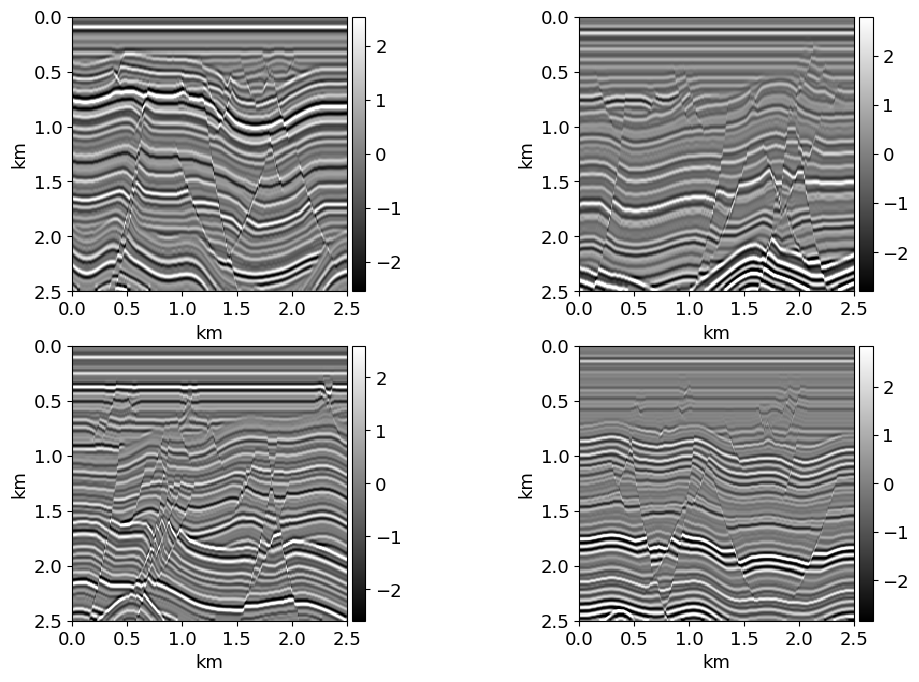

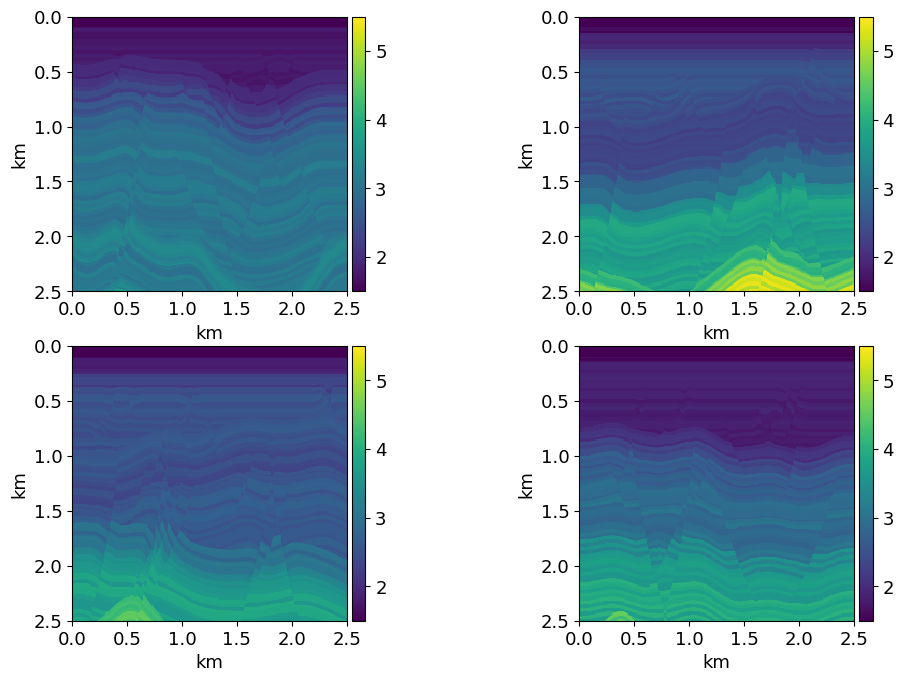

In [23]:
# Load the HDF5 file with the following commands (this is helpful when you want to open the file outside this notebook)
from utils_data import load_all_models, pclip
from mpl_toolkits.axes_grid1 import make_axes_locatable
ref_p,ref_i,v,v0 = load_all_models(train_path)[0:4]

# Parameters for plotting
rows = 2
columns = 2
fs=13
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#==========================
# Plotting reflectivities =
#==========================
ix=0	#first model index
fig, axes = plt.subplots(nrows=rows,ncols=columns)
vmin, vmax = pclip(ref_p[ix])
# First model
im1=axes[0,0].imshow(ref_p[ix].transpose(1,0),extent=(0,2.5,2.5,0), cmap='gray',vmin=vmin,vmax=vmax)
axes[0,0].set_xlabel('km',fontsize=fs)
axes[0,0].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[0,0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)
# Second model
vmin, vmax = pclip(ref_p[ix+1])
im2=axes[0,1].imshow(ref_p[ix+1].transpose(1,0),extent=(0,2.5,2.5,0), cmap='gray',vmin=vmin,vmax=vmax)
axes[0,1].set_xlabel('km',fontsize=fs)
axes[0,1].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[0,1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)
# Thrid model
vmin, vmax = pclip(ref_p[ix+2])
im3=axes[1,0].imshow(ref_p[ix+2].transpose(1,0),extent=(0,2.5,2.5,0), cmap='gray',vmin=vmin,vmax=vmax)
axes[1,0].set_xlabel('km',fontsize=fs)
axes[1,0].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[1,0])
cax3 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3)
# Fourth Model
vmin, vmax = pclip(ref_p[ix+3])
im4=axes[1,1].imshow(ref_p[ix+3].transpose(1,0),extent=(0,2.5,2.5,0), cmap='gray',vmin=vmin,vmax=vmax)
axes[1,1].set_xlabel('km',fontsize=fs)
axes[1,1].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[1,1])
cax4 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im4, cax=cax4)

#==========================
# Plotting fake seismic   =
#==========================
fig, axes = plt.subplots(nrows=rows,ncols=columns)
vmin, vmax = pclip(ref_i[ix])
# First model
im1=axes[0,0].imshow(ref_i[ix].transpose(1,0),extent=(0,2.5,2.5,0), cmap='gray',vmin=vmin,vmax=vmax)
axes[0,0].set_xlabel('km',fontsize=fs)
axes[0,0].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[0,0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)
# Second model
vmin, vmax = pclip(ref_i[ix+1])
im2=axes[0,1].imshow(ref_i[ix+1].transpose(1,0),extent=(0,2.5,2.5,0), cmap='gray',vmin=vmin,vmax=vmax)
axes[0,1].set_xlabel('km',fontsize=fs)
axes[0,1].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[0,1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)
# Thrid model
vmin, vmax = pclip(ref_i[ix+2])
im3=axes[1,0].imshow(ref_i[ix+2].transpose(1,0),extent=(0,2.5,2.5,0), cmap='gray',vmin=vmin,vmax=vmax)
axes[1,0].set_xlabel('km',fontsize=fs)
axes[1,0].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[1,0])
cax3 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3)
# Fourth Model
vmin, vmax = pclip(ref_i[ix+3])
im4=axes[1,1].imshow(ref_i[ix+3].transpose(1,0),extent=(0,2.5,2.5,0), cmap='gray',vmin=vmin,vmax=vmax)
axes[1,1].set_xlabel('km',fontsize=fs)
axes[1,1].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[1,1])
cax4 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im4, cax=cax4)

#==========================
# Plotting velocities     =
#==========================
fig, axes = plt.subplots(nrows=rows,ncols=columns)
vmin, vmax = [1.5,5.5]
# First model
im1=axes[0,0].imshow(v[ix].transpose(1,0),extent=(0,2.5,2.5,0), cmap='viridis',vmin=vmin,vmax=vmax)
axes[0,0].set_xlabel('km',fontsize=fs)
axes[0,0].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[0,0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)
# Second model
im2=axes[0,1].imshow(v[ix+1].transpose(1,0),extent=(0,2.5,2.5,0), cmap='viridis',vmin=vmin,vmax=vmax)
axes[0,1].set_xlabel('km',fontsize=fs)
axes[0,1].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[0,1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)
# Thrid model
im3=axes[1,0].imshow(v[ix+2].transpose(1,0),extent=(0,2.5,2.5,0), cmap='viridis',vmin=vmin,vmax=vmax)
axes[1,0].set_xlabel('km',fontsize=fs)
axes[1,0].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[1,0])
cax3 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3)
# Fourth Model
im4=axes[1,1].imshow(v[ix+3].transpose(1,0),extent=(0,2.5,2.5,0), cmap='viridis',vmin=vmin,vmax=vmax)
axes[1,1].set_xlabel('km',fontsize=fs)
axes[1,1].set_ylabel('km',fontsize=fs)
divider = make_axes_locatable(axes[1,1])
cax4 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im4, cax=cax4)
